In [1]:
from itertools import chain
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, GlobalAveragePooling2D, LSTM, TimeDistributed, Dropout, Dense
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm
import pandas as pd

from data import Data

In [2]:
LABEL_INDEX = {
    'ap': 0,
    'bs': 1,
    'mid': 2,
    'oap': 3,
    'obs': 4,
}

In [3]:
data = Data()

In [4]:
dataset = 'CAT'
phase = 0

patients = data.data[dataset]
patients = sorted(patients.items())
phases = [p[1][phase] for p in patients]
def dict_to_ordered_list(d):
    items = sorted(d.items())
    return [item[1] for item in items]
phases = [dict_to_ordered_list(d) for d in phases]  # for LSTM training
slices = list(chain(*phases))  # for CNN training
slice_labels = [data.labels[s] for s in slices]

In [340]:
def path_to_array(path, target_size=(224, 224)):
    image = Image.open(data.paths[path])
    image = image.resize(target_size, Image.NEAREST)
    image = img_to_array(image)
    image = np.repeat(image, 3, axis=2)
    image = image.astype('float32') / 256 / 256
    return image

In [342]:
slice_x = np.stack([path_to_array(path) for path in slices])
slice_y = np.array([LABEL_INDEX[label] for label in slice_labels])
slice_y = to_categorical(slice_y)
cut70 = slice_x.shape[0] * 7 // 10

slice_tx = slice_x[:cut70]
slice_vx = slice_x[cut70:]
slice_ty = slice_y[:cut70]
slice_vy = slice_y[cut70:]

In [343]:
mob = keras.applications.mobilenet.MobileNet(include_top=False, pooling='avg', weights='imagenet', input_shape=(224, 224, 3))

In [344]:
slice_xe = mob.predict(slice_x)

In [345]:
slice_xe.shape

(1261, 1024)

In [347]:
slice_txe = slice_xe[:cut70]
slice_vxe = slice_xe[cut70:]

In [354]:
cnn_model = Sequential()
cnn_model.add(Dense(512, activation="relu"))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(512, activation="relu"))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(5, activation="softmax"))

cnn_model.compile(loss='categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])

In [355]:
cnn_history = cnn_model.fit(slice_txe, slice_ty, validation_data=(slice_vxe, slice_vy), batch_size=32, epochs=100)

Epoch 1/100
28/28 [==============================] - 0s 7ms/step - loss: 1.7887 - accuracy: 0.3458 - val_loss: 1.0745 - val_accuracy: 0.4538
Epoch 2/100
28/28 [==============================] - 0s 4ms/step - loss: 1.1343 - accuracy: 0.5045 - val_loss: 0.8154 - val_accuracy: 0.7045
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 0.8829 - accuracy: 0.6304 - val_loss: 0.7585 - val_accuracy: 0.6412
Epoch 4/100
28/28 [==============================] - 0s 4ms/step - loss: 0.7776 - accuracy: 0.6814 - val_loss: 0.7899 - val_accuracy: 0.6464
Epoch 5/100
28/28 [==============================] - 0s 4ms/step - loss: 0.7295 - accuracy: 0.6961 - val_loss: 0.6487 - val_accuracy: 0.7335
Epoch 6/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6208 - accuracy: 0.7653 - val_loss: 0.6772 - val_accuracy: 0.7018
Epoch 7/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6136 - accuracy: 0.7392 - val_loss: 0.6863 - val_accuracy: 0.6992
Epoch 8/100
2

Epoch 59/100
28/28 [==============================] - 0s 4ms/step - loss: 0.1621 - accuracy: 0.9410 - val_loss: 1.1747 - val_accuracy: 0.7335
Epoch 60/100
28/28 [==============================] - 0s 4ms/step - loss: 0.1466 - accuracy: 0.9467 - val_loss: 1.1348 - val_accuracy: 0.7309
Epoch 61/100
28/28 [==============================] - 0s 4ms/step - loss: 0.1398 - accuracy: 0.9478 - val_loss: 1.1630 - val_accuracy: 0.7361
Epoch 62/100
28/28 [==============================] - 0s 4ms/step - loss: 0.1259 - accuracy: 0.9569 - val_loss: 1.2784 - val_accuracy: 0.7177
Epoch 63/100
28/28 [==============================] - 0s 4ms/step - loss: 0.1363 - accuracy: 0.9422 - val_loss: 1.1874 - val_accuracy: 0.7230
Epoch 64/100
28/28 [==============================] - 0s 4ms/step - loss: 0.1617 - accuracy: 0.9376 - val_loss: 1.1315 - val_accuracy: 0.7150
Epoch 65/100
28/28 [==============================] - 0s 4ms/step - loss: 0.1448 - accuracy: 0.9376 - val_loss: 1.0444 - val_accuracy: 0.7309
Epoch 

In [363]:
array = np.ones((12, 224, 224, 3))

In [398]:
def slice_list_to_array(slices):
    stack = np.stack([path_to_array(path) for path in slices])
    stack = mob.predict(stack)
    remaining = 25 - stack.shape[0]
    stack = np.pad(stack, [(0, remaining), (0,0), ], constant_values=0)
    return stack

def slice_list_to_label_array(slices):
    labels = [data.labels[s] for s in slices]
    labels = np.array([LABEL_INDEX[label] for label in labels])
    labels = to_categorical(labels, num_classes=5)
    remaining = 25 - labels.shape[0]
    labels = np.pad(labels, [(0, remaining), (0, 0)], constant_values=0)
    return labels

patient_x = []
for phase in tqdm(phases):
    patient_x.append(slice_list_to_array(phase))
patient_x = np.stack(patient_x)
patient_y = np.stack([slice_list_to_label_array(p) for p in phases])

100%|██████████| 100/100 [00:29<00:00,  3.44it/s]


In [402]:
print(patient_x.shape)
print(patient_y.shape)

(100, 25, 1024)
(100, 25, 5)


In [400]:
cut70 = patient_x.shape[0] * 7 // 10

patient_tx = patient_x[:cut70]
patient_vx = patient_x[cut70:]
patient_ty = patient_y[:cut70]
patient_vy = patient_y[cut70:]

In [412]:
rnn_model = Sequential()
rnn_model.add(LSTM(512, input_shape=(25, 1024), return_sequences=True))
rnn_model.add(Dropout(0.5))
rnn_model.add(LSTM(512, input_shape=(25, 1024), return_sequences=True))
rnn_model.add(Dropout(0.5))
rnn_model.add(TimeDistributed(Dense(5, activation="softmax")))
rnn_model.compile(loss='categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])

In [413]:
rnn_history = rnn_model.fit(patient_tx, patient_ty, validation_data=(patient_vx, patient_vy), batch_size=4, epochs=100)

Epoch 1/100
18/18 [==============================] - 4s 198ms/step - loss: 0.8336 - accuracy: 0.2417 - val_loss: 0.7170 - val_accuracy: 0.1880
Epoch 2/100
18/18 [==============================] - 3s 158ms/step - loss: 0.6733 - accuracy: 0.2463 - val_loss: 0.5040 - val_accuracy: 0.4000
Epoch 3/100
18/18 [==============================] - 3s 192ms/step - loss: 0.4578 - accuracy: 0.4349 - val_loss: 0.4525 - val_accuracy: 0.4907
Epoch 4/100
18/18 [==============================] - 3s 152ms/step - loss: 0.3747 - accuracy: 0.4823 - val_loss: 0.3448 - val_accuracy: 0.4560
Epoch 5/100
18/18 [==============================] - 3s 166ms/step - loss: 0.3382 - accuracy: 0.5371 - val_loss: 0.3648 - val_accuracy: 0.6613
Epoch 6/100
18/18 [==============================] - 3s 161ms/step - loss: 0.2827 - accuracy: 0.6309 - val_loss: 0.3072 - val_accuracy: 0.7360
Epoch 7/100
18/18 [==============================] - 3s 156ms/step - loss: 0.2712 - accuracy: 0.6691 - val_loss: 0.3633 - val_accuracy: 0.6307

Epoch 58/100
18/18 [==============================] - 3s 142ms/step - loss: 0.0213 - accuracy: 0.7726 - val_loss: 0.6414 - val_accuracy: 0.7520
Epoch 59/100
18/18 [==============================] - 3s 145ms/step - loss: 0.0288 - accuracy: 0.8154 - val_loss: 0.4671 - val_accuracy: 0.7973
Epoch 60/100
18/18 [==============================] - 3s 151ms/step - loss: 0.0432 - accuracy: 0.7983 - val_loss: 0.6895 - val_accuracy: 0.7347
Epoch 61/100
18/18 [==============================] - 3s 149ms/step - loss: 0.0533 - accuracy: 0.8080 - val_loss: 0.5409 - val_accuracy: 0.7747
Epoch 62/100
18/18 [==============================] - 3s 142ms/step - loss: 0.0393 - accuracy: 0.8160 - val_loss: 0.5537 - val_accuracy: 0.8027
Epoch 63/100
18/18 [==============================] - 2s 138ms/step - loss: 0.0304 - accuracy: 0.8137 - val_loss: 0.5431 - val_accuracy: 0.8147
Epoch 64/100
18/18 [==============================] - 3s 151ms/step - loss: 0.0233 - accuracy: 0.8234 - val_loss: 0.5745 - val_accuracy:

In [477]:
history = {}
history["cnn_val_acc"] = cnn_history.history["val_accuracy"]
history["rnn_val_acc"] = rnn_history.history["val_accuracy"]

<AxesSubplot:>

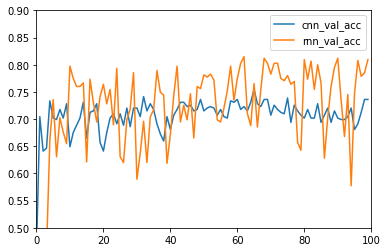

In [480]:
pd.DataFrame(history).plot(xlim=[0, 100], ylim=[0.5, 0.9])

In [451]:
vp = rnn_model.predict(patient_vx)

In [461]:
correct = 0
valid = 0
for i in range(30):
    for j in range(25):
        prediction = tf.argmax(vp[i][j]).numpy()
        if np.count_nonzero(patient_vy[i][j]) == 1:
            valid += 1
        if patient_vy[i][j][prediction] == 1:
            correct += 1
correct / valid

0.7893258426966292

In [464]:
slice_vp = cnn_model.predict(slice_vxe)

In [467]:
correct = 0
valid = 0
for i in range(379):
    prediction = tf.argmax(slice_vp[i]).numpy()
    if np.count_nonzero(slice_vy[i]) == 1:
        valid += 1
    if slice_vy[i][prediction] == 1:
        correct += 1
correct / valid

0.7361477572559367